In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from functions.poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

from tqdm.auto import tqdm, trange

## Percent voting people

In [6]:
voters = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

## Stat data

In [7]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [8]:
stat_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:-1]]

In [9]:
for yi in range(len(stat_list)):
    y = files[yi].split('.')[0]
    c = stat_list[yi].columns
    c = [y+'-'+ci for ci in c]
    # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
    stat_list[yi].columns = c

## Poll data

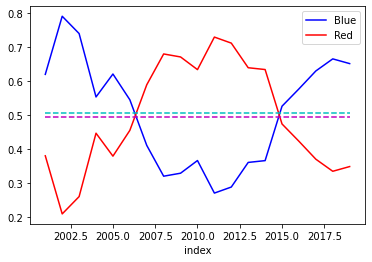

In [10]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/percent_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [11]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [12]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [13]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [14]:
vote_list[0] = vote_list[0].set_index('województwo')

In [15]:
if(False):
    for yi in range(len(vote_list)):
        y = files[yi].split('_WS')[0]
        c = vote_list[yi].columns
        #c = [y+'-'+ci for ci in c]
        # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
        vote_list[yi].columns = c

        #vote_list[yi] = vote_list[yi].div(vote_list[yi].sum(axis=1), axis=0).fillna(0)

## Neighbours

In [16]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Use 2 approaches to estimate date from years without elections

In [17]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [18]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1]

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [19]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

In [20]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(pool_data_middle.shape[0]-1):
    # iterate over districts
    tmp_x = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        p = pool_data_middle['Blue'].values[y]
        
        tmp_x.append([lo[0]/lo.sum(), avg_n, p])
    X.append(tmp_x)

In [21]:
X = np.array(X)
X.shape

(18, 16, 3)

## Prepare Y

In [22]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [23]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [24]:
X.shape

(18, 16, 3)

### Models with percentage of Blue support per district

In [26]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x3
    x - vector of input data 18x16x3
    OUTPUT:
    y - predicted value in (0,1)
    '''
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, 3)
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True) ))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x3
    x - vector of input data 18x16x3
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, 3)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x*a,1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x*a,1,keepdims=True)))**2 *
          np.exp(-np.sum(x*a,1,keepdims=True)) *
          x)
    
    return y1

### Setup for testing model

In [27]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = pool_d[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = pool_d[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

#### Model:

Input| Output
:---|:---
1. output to last election | 1. output of current election
2. avg over neighbours of last election | 
3. global value of polling |

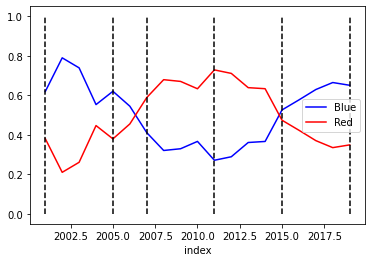

In [28]:
pool_data_middle.plot(color=['b','r'])
for y in [2001,2005,2007,2011,2015,2019]:
    plt.plot([y,y],[0,1], 'k--')
plt.show()

In [29]:
def prepare_input(y, pool=pool_data_middle, year=0):
    tmp_x = np.zeros((y.shape[0],3))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        p = pool['Blue'].values[year]
        
        tmp_x[d] = np.array([y[d,0], avg_n, p])
    return(tmp_x)

In [30]:
def model(a,x,Y,pool=pool_data_middle):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        xi = prepare_input(y,pool,year)
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

## Setup random a

In [31]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
a_nxt = a_avg
a_wgth = a_avg
a_tmp = a_avg

step = 1
beta = 0.01

## All at once

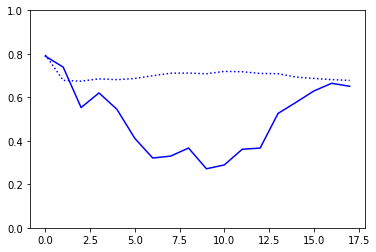

In [32]:
a_avg = np.random.rand(X.shape[1],X.shape[2])-0.5
for epoch in range(100):
    grad = grad_percent(a_avg,X,Y).reshape(18,16,3)

    #if epoch==0: print('first grad max/min:', np.max(grad),'/',np.min(grad))
    grad = np.sum(grad, axis=0)

    #if epoch==0: print('first grad max/min:', np.max(grad),'/',np.min(grad))
    a_avg = a_avg - step*grad

    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    #if epoch%1==0: print('loss sum:',loss_p)

l, o = model(a_avg,X,Y)

plt.plot(np.mean(o,1),'b:')
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## Shuffle years and on at once

loss sum: 7.057742428415816
loss sum: 5.125231264067503
loss sum: 4.375033997237304
loss sum: 4.222920594551932
loss sum: 4.126247791849964
loss sum: 3.9381883395422443
loss sum: 3.871252860722605
loss sum: 3.847618639867473
loss sum: 3.782159843093874
loss sum: 3.746293805798647


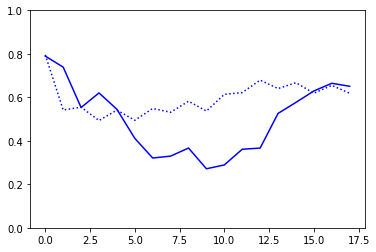

In [35]:
a_all = np.random.rand(X.shape[1],X.shape[2])-0.5
loss_l = np.inf

for epoch in range(10**3):
    shuffle_i = np.arange(X.shape[0])
    np.random.shuffle(shuffle_i)
    loss_p = 0
    for i in shuffle_i:
        grad = grad_percent(a_all,X[i],Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_all = a_all - step*grad

        #if epoch%50==0: 
        #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
        #    else: step /= (1-beta)

        loss_p += np.sum((model_percent(a_all,X[i]) - Y[i].reshape(-1,1))**2)

    #if loss_p > loss_l: 
        #print('loss sum:',loss_p)
        #break

    loss_l = loss_p

    if epoch%100==0: 
        print('loss sum:',loss_p)
        n = epoch//(100)
        if(n<9):
            l, o = model(a_all,X,Y)
            #arr[i,n] = np.mean(o,1).reshape(-1)
            #ax[n//3,n%3].plot(np.mean(o,1),'b--')
            #ax[n//3,n%3].plot(pool_data_middle['Blue'].values[1:],'b')
            #ax[n//3,n%3].set_ylim(0,1)

l, o = model(a_all,X,Y)
plt.plot(np.mean(o,1),'b:')

plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## Use output -> next input (grad each step)

loss sum: 7.030970671597004
loss sum: 2.957735642412948
loss sum: 2.4908017233763284
loss sum: 2.289866746884374
loss sum: 2.186588671881185
loss sum: 2.127638691764652
loss sum: 2.0920896961645545
loss sum: 2.070984919007615
loss sum: 2.0588478934896153
loss sum: 2.051965750009177


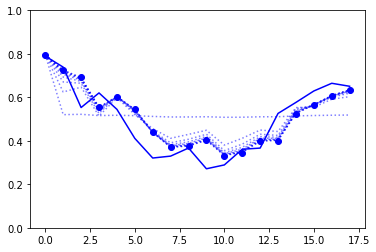

In [36]:
a_step = np.random.rand(X.shape[1],X.shape[2])-0.5
for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,year=i)
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
        l, o = model(a_step,X,Y)
        plt.plot(np.mean(o,1),'b:', alpha=0.5)

l, o = model(a_step,X,Y)
plt.plot(np.mean(o,1),'bo')

plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

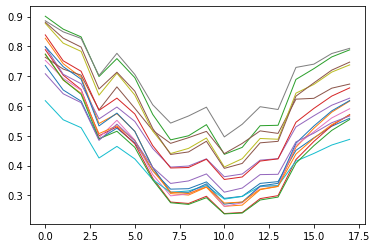

In [37]:
l, o = model(a_step,X,Y)
plt.plot(o.reshape(18,16), linewidth=1)
plt.show()

## Use output -> next input (grad each epoch)

loss sum: 9.585344491252517
loss sum: 7.311931749186411
loss sum: 6.505159959728665
loss sum: 6.1532450213960335
loss sum: 5.992654365198857
loss sum: 5.920935457580067
loss sum: 5.890732092531412
loss sum: 5.878957985423189
loss sum: 5.874616839584512
loss sum: 5.872838993923716


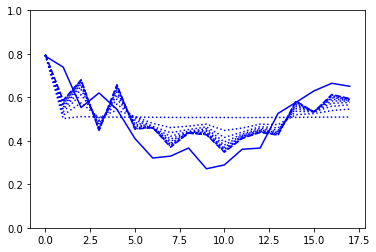

In [40]:
# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
#fig, ax = plt.subplots(nrows=2, ncols=2)

loss_l = np.inf
a_nxt = np.random.rand(X.shape[1],X.shape[2])-0.5
step = 0.01

for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    grad = np.zeros(X[0].shape)
    
    for i in range(1,X.shape[0]):
        xi = prepare_input(y,year=i)
        y = model_percent(a_nxt,xi)
        grad += grad_percent(a_nxt,xi,Y[i])
        loss_p += np.sum((model_percent(a_nxt,xi) - Y[i].reshape(-1,1))**2)
    
    grad = np.sum(grad, axis=0)
    
    #if loss_p > loss_l: 
    #    print('loss sum:',loss_p)
    #    break
    a_nxt = a_nxt - step*grad
    loss_l = loss_p
    
    if epoch%100==0: 
        print('loss sum:',loss_p)
        n = epoch//(10)
        l, o = model(a_nxt,X,Y)
        plt.plot(np.mean(o,1),'b:')
        '''
        if(n<9):
            l, o = model(a_nxt,X,Y)
            ax[n//2,n%2].plot(np.mean(o,1),'b--')
            ax[n//2,n%2].plot(pool_data_middle['Blue'].values[1:],'b')
            ax[n//2,n%2].set_ylim(0,1)
        '''
l, o = model(a_nxt,X,Y)

plt.plot(np.mean(o,1),'b--')
plt.plot(pool_data_middle['Blue'].values[1:],'b')
plt.ylim(0,1)

plt.show()


## Use output -> next input (grad each step) + weights(linear weight)

In [41]:
#fig, ax = plt.subplots(nrows=3, ncols=3)

a_step_wgth = np.random.rand(X.shape[1],X.shape[2])-0.5
step = 10
loss_l=np.inf 

for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,year=i)
        y = model_percent(a_step_wgth,xi)

        grad = grad_percent(a_step_wgth,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step_wgth = a_step_wgth - grad*(i+1)/X.shape[0]*step

        loss_p += np.sum((model_percent(a_step_wgth,xi) - Y[i].reshape(-1,1))**2)
    
    #if loss_l<loss_p:
    #    break
    
    if epoch%100==0: 
        #print('loss sum:',loss_p)
        l, o = model(a_step_wgth,X,Y)
        #plt.plot(np.mean(o,1),'b:', alpha=0.5)
        '''
        n = epoch//(500)
        if(n<9):
            l, o = model(a_step_wgth,X,Y)
            ax[n//3,n%3].plot(np.mean(o,1),'b--')
            ax[n//3,n%3].plot(pool_data_middle['Blue'].values[1:],'b')
            ax[n//3,n%3].set_ylim(0,1)
        '''
l, o = model(a_step_wgth,X,Y)

plt.plot(np.mean(o,1),'b*')
plt.plot(pool_data_middle['Blue'].values[1:],'bo')
plt.ylim(0,1)
plt.show()

KeyboardInterrupt: 

## Use output -> next input (grad each epoch) + weights(linear weight)

In [78]:
# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
loss_l = np.inf
a_wgth = np.random.rand(X.shape[1],X.shape[2])-0.5

loss sum: 9.260321839315967
loss sum: 18.087038715818885
loss sum: 17.3729336930343
loss sum: 15.835442736197649
loss sum: 22.00351820861699
loss sum: 21.96545221874357
loss sum: 21.92643542679666
loss sum: 21.88641850212049
loss sum: 21.845348151194017
loss sum: 21.803166680120867


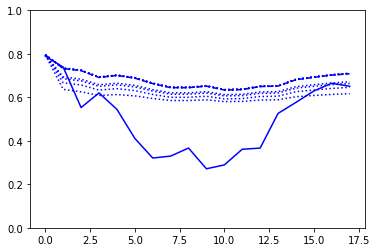

In [79]:
#fig, ax = plt.subplots(nrows=2, ncols=2)
step = 0.1

for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    grad = np.zeros(X[0].shape)
    
    for i in range(1,X.shape[0]):
        xi = prepare_input(y,year=i)
        y = model_percent(a_wgth,xi)
        grad += grad_percent(a_wgth,xi,Y[i])*(i+1)/X.shape[0]
        loss_p += np.sum((model_percent(a_wgth,xi) - Y[i].reshape(-1,1))**2)
    
    grad = np.sum(grad, axis=0)
    
    #if loss_p > loss_l: 
    #    print('loss sum:',loss_p)
    #    break
    a_wgth = a_wgth - step*grad
    loss_l = loss_p
    
    if epoch%100==0: 
        print('loss sum:',loss_p)
        n = epoch//(100)
        if(n<9):
            l, o = model(a_wgth,X,Y)
            plt.plot(np.mean(o,1),'b:')
            #ax[n//2,n%2].plot(np.mean(o,1),'b--')
            #ax[n//2,n%2].plot(pool_data_middle['Blue'].values[1:],'b')
            #ax[n//2,n%2].set_ylim(0,1)
l, o = model(a_wgth,X,Y)

plt.plot(np.mean(o,1),'b--')
plt.plot(pool_data_middle['Blue'].values[1:],'b')
plt.ylim(0,1)
plt.show()


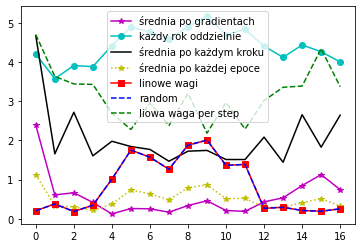

In [47]:
l_avg, o_avg = model(a_avg,X,Y)
l_all, o_all = model(a_all,X,Y)
l_step, o_step = model(a_step,X,Y)
l_nxt, o_nxt = model(a_nxt,X,Y)
l_wgth, o_wgth = model(a_wgth,X,Y)
l_rnd, o_rnd = model(a_tmp,X,Y)
l_tp_w, o_stp_w = model(a_step_wgth,X,Y)

plt.plot(l_avg,'m-*')
plt.plot(l_all,'c-o')
plt.plot(l_step,'k-') 
plt.plot(l_nxt,'y:*')
plt.plot(l_wgth,'r-s')
plt.plot(l_rnd,'b--')
plt.plot(l_tp_w,'g--')

#plt.plot([0,16],[np.mean(l_avg),np.mean(l_avg)],'m--')
#plt.plot([0,16],[np.mean(l_all),np.mean(l_all)],'c--')
#plt.plot([0,16],[np.mean(o_step),np.mean(o_step)],'k--')
#plt.plot([0,16],[np.mean(l_nxt),np.mean(l_nxt)],'y--')
#plt.plot([0,16],[np.mean(l_wgth),np.mean(l_wgth)],'r--')

plt.legend(['średnia po gradientach', 
            'każdy rok oddzielnie', 
            'średnia po każdym kroku',
            'średnia po każdej epoce', 
            'linowe wagi',
            'random',
            'liowa waga per step'
           ])

plt.savefig('model/compare_gradient_outputs.pdf', bbox_inches='tight')#, format='eps')

(0.0, 1.0)

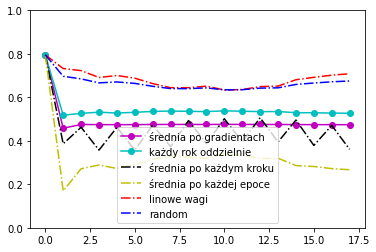

In [81]:
plt.plot(o_avg.mean(1), 'm-o')
plt.plot(o_all.mean(1), 'c-o')
plt.plot(o_step.mean(1), 'k-.')
plt.plot(o_nxt.mean(1), 'y-.')
plt.plot(o_wgth.mean(1), 'r-.')
plt.plot(o_rnd.mean(1), 'b-.')

plt.legend(['średnia po gradientach', 
            'każdy rok oddzielnie', 
            'średnia po każdym kroku',
            'średnia po każdej epoce', 
            'linowe wagi',
            'random'
           ])
plt.ylim(0,1)

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [75]:
pool_d_real = [pd.sum(0) for pd in pool_d]

In [76]:
pool_d_real = pd.concat(pool_d_real, axis=1)
pool_d_real.columns = [2001 + i for i in range(19)]

In [77]:
pool_d_real = pool_d_real/pool_d_real.sum(0)

In [78]:
pool_d_real

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Blue,0.742391,0.916187,0.89227,0.787312,0.600714,0.646449,0.428687,0.267259,0.274891,0.307473,0.31236,0.155088,0.202177,0.205785,0.567657,0.639133,0.686543,0.717959,0.595992
Red,0.257609,0.083813,0.10773,0.212688,0.399286,0.353551,0.571313,0.732741,0.725109,0.692527,0.68764,0.844912,0.797823,0.794215,0.432343,0.360867,0.313457,0.282041,0.404008


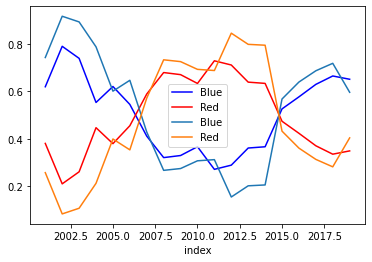

In [79]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
fig, ax = plt.subplots()

pool_data_middle = pd.read_csv('dane_years/pools_data/percent_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'], ax=ax)
pool_d_real.T.plot(ax=ax)
plt.show()